## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Get calibration coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save undistorted chessboard images
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(gray, mtx, dist, None, mtx)
    fname_arr = fname.split('/')
    undist_image_name = "./output_images/" + fname_arr[len(fname_arr) - 1]
    mpimg.imsave(undist_image_name, undist, cmap="gray")

## Step 2: Distortion Correction

In [2]:
def undistort(img):
    # Undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Step 3: Color & Gradient Threshold

In [3]:
def threshold(img, s_thresh=(140, 200), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls_h_channel = hls[:,:,0]
    hls_l_channel = hls[:,:,1]
    hls_s_channel = hls[:,:,2]
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    hsv_h_channel = hsv[:,:,0]
    hsv_s_channel = hsv[:,:,1]
    hsv_v_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(hls_l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(hls_s_channel)
    s_binary[(hls_s_channel >= s_thresh[0]) & (hls_s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    l_binary = np.zeros_like(sxbinary)
    color_binary = np.dstack((l_binary, sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

## Step 4: Perspective Transform

### Get perspective point for project_movie

In [4]:
def getPerspectiveTransformForImage(image):
    img_size = (image.shape[1], image.shape[0])
    srcp = np.float32(
                    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
                    [((img_size[0] / 6) - 10), img_size[1]],
                    [(img_size[0] * 5 / 6) + 90, img_size[1]],
                    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
    dstp = np.float32(
                    [[(img_size[0] / 4), 0],
                    [(img_size[0] / 4), img_size[1]],
                    [(img_size[0] * 3 / 4), img_size[1]],
                    [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(srcp, dstp)
    Minv = cv2.getPerspectiveTransform(dstp, srcp)
    return M, Minv
    

### Print sample images (undistorted & transformed)

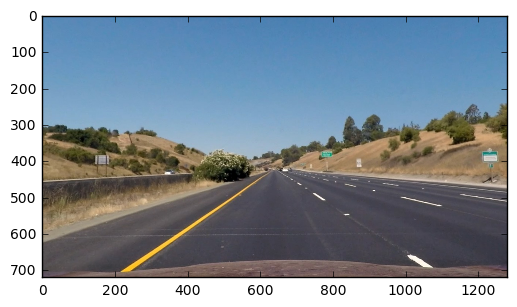

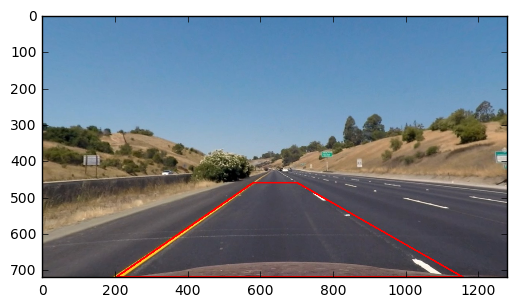

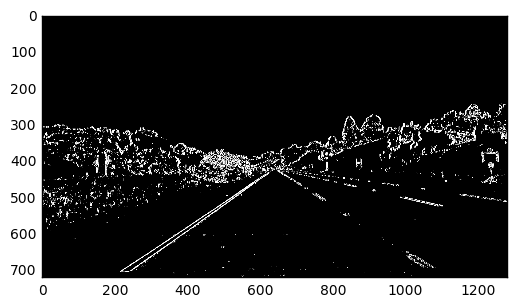

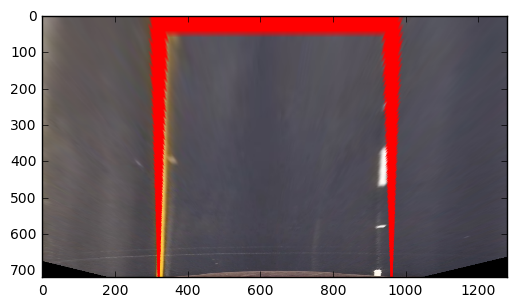

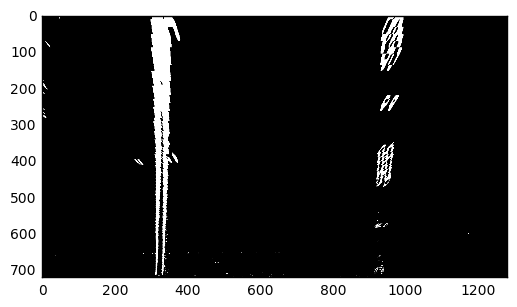

In [5]:
image_name = "./test_images/straight_lines1.jpg"
output_image_name = "./output_images/straight_lines1_output.jpg"
output_image_name_threshold = "./output_images/straight_lines1_thresh.jpg"
trans_undst_image_name = "./output_images/straight_lines1_undst_trans.jpg"
trans_image_name = "./output_images/straight_lines1_trans.jpg"

test_image = cv2.imread(image_name)
image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
img_size = (image.shape[1], image.shape[0])

srcp = np.array(
                    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
                    [((img_size[0] / 6) - 10), img_size[1]],
                    [(img_size[0] * 5 / 6) + 90, img_size[1]],
                    [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]], np.int32).reshape(-1,1,2)

# Use the camera calibration to undistort
undst = undistort(image)
plt.imshow(undst)
plt.show()
mpimg.imsave(output_image_name, undst)

# Gaussian blur
#blur = cv2.GaussianBlur(undst, (5, 5), 0)
#plt.imshow(blur)
#plt.show()

undst_selection = undistort(undst)
cv2.polylines(undst_selection, [srcp], True, (255,0,0), 3)

# Perform gradient and color threshold
grad = threshold(undst)

plt.imshow(undst_selection)
plt.show()
plt.imshow(grad, cmap="gray")
plt.show()
mpimg.imsave(output_image_name_threshold, grad, cmap="gray")

# Perspective transform
M, Minv = getPerspectiveTransformForImage(image)


warped_undst = cv2.warpPerspective(undst_selection, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped_undst)
plt.show()
mpimg.imsave(trans_undst_image_name, warped_undst)

warped = cv2.warpPerspective(grad, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")
plt.show()
mpimg.imsave(trans_image_name, warped, cmap="gray")

## Step 5:  Lane Lines

In [6]:
# Define a class to receive the characteristics of each line detection
# Define conversions in x and y from pixels space to meters
g_ym_per_pix = 30/720 # meters per pixel in y dimension
g_xm_per_pix = 3.7/700 # meters per pixel in x dimension
class Line():
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        #polynomial coefficients for the last n fit
        self.recent_fit = [] 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Count number of invalid frames
        self.invalid_frames = 5


### Detect Lines

In [7]:
# Global variables to keep track of when to print
# curvature and offset from center distance. Updating 
# these values every frame makes it very jittery.
g_frameCount = 10
g_curvature_str = None
g_offset_str = None

def findLines(image, left_line, right_line, visualize=False):
    
    if (left_line.detected and right_line.detected):
        # If the we have valid prior line data
        left_fit, right_fit = _findLines(image, left_line, right_line, False)
        if (left_fit != None) and (right_fit != None):
            # Compute of the last 5 frames
            left_line.current_fit = left_fit
            right_line.current_fit = right_fit

            # Add to recent fit
            left_line.recent_fit.append(left_line.current_fit)
            left_line.recent_fit[-5:]
            right_line.recent_fit.append(right_line.current_fit)
            right_line.recent_fit[-5:]
    else:
        left_line.invalid_frames += 1
        
        if (left_line.invalid_frames < 5):
            # Use the average of the recent frame
            left_line.current_fit = np.mean(left_line.recent_fit, axis=0)
            right_line.current_fit = np.mean(right_line.recent_fit, axis=0)
        else:
            # Run the the histogram and sliding window algorithm again 
            # to find the line. Invalidate previously saved recent values
            left_line.recent_fit = []
            right_line.recent_fit = []
            left_fit, right_fit = _findLines(image, left_line, right_line, True)
    
            if ((left_line.current_fit == None) or (right_line.current_fit == None)):
                left_line.invalid_frames = 0

    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    right_fitx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]

    left_line.recent_xfitted.append(left_fitx)
    left_line.recent_xfitted[-5:]
    left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
    right_line.recent_xfitted.append(right_fitx)
    right_line.recent_xfitted[-5:]
    right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)

    left_line.best_fit = np.polyfit(ploty, left_fitx, 2)
    right_line.best_fit = np.polyfit(ploty, right_fitx, 2)

    return None

def _findLines(image, left_line, right_line, searchForLines=False):
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Line is marked as not detected unless we find it in this function
    left_line.detected = False
    right_line.detected = False
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if (searchForLines):
        # Code from Advanced Lane Finding lecture
        # Take a histogram of the bottom half of the image
        histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((image, image, image))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(image.shape[0]/nwindows)
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    else:
        left_lane_inds = ((nonzerox < (left_line.best_fit[0]*(nonzeroy**2) + left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] + margin)) & (nonzerox > (left_line.best_fit[0]*(nonzeroy**2) + left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] - margin))) 
        right_lane_inds = ((nonzerox < (right_line.best_fit[0]*(nonzeroy**2) + right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] + margin)) & (nonzerox > (right_line.best_fit[0]*(nonzeroy**2) + right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] - margin)))

        
    # Extract left and right line pixel positions
    left_x = nonzerox[left_lane_inds]
    left_y = nonzeroy[left_lane_inds] 
    right_x = nonzerox[right_lane_inds]
    right_y = nonzeroy[right_lane_inds] 
    
    if (len(left_x) == 0) or (len(right_x) == 0):
        return None, None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2) 
    
    left_curve = _calculateCurvature(image, left_fit)
    right_curve = _calculateCurvature(image, right_fit)
    
    if (_validLines(left_curve, right_curve, left_x, right_x, left_y, right_y)):
        left_line.radius_of_curvature = left_curve
        left_line.current_fit = left_fit
        left_line.detected = True
        left_line.allx = left_x
        left_line.ally = left_y
        
        right_line.radius_of_curvature = right_curve
        right_line.current_fit = right_fit
        right_line.detected = True
        right_line.allx = right_x
        right_line.ally = right_y
        
        left_line.detected = True
        right_line.detected = True
    
        return left_fit, right_fit

    return None, None

def _validCurve(left_curve, right_curve):
    curve_diff = abs(left_curve - right_curve)
    if (curve_diff > 2000):
        #print("Curvature: ", left_curve, right_curve, curve_diff)
        return False
    
    return True

def _validSlopeAndHorizontalDiff(left_x, right_x, left_y, right_y):

    left_y_5th_percentile = np.percentile(left_y, 5)
    left_y_95th_percentile = np.percentile(left_y, 95)
    right_y_5th_percentile = np.percentile(right_y, 5)
    right_y_95th_percentile = np.percentile(right_y, 95)

    top_l = [i for i,v in enumerate(left_y) if v < left_y_5th_percentile]
    top_r = [i for i,v in enumerate(right_y) if v < right_y_5th_percentile]
    bottom_l = [i for i,v in enumerate(left_y) if v > left_y_95th_percentile]
    bottom_r = [i for i,v in enumerate(right_y) if v > right_y_95th_percentile]
    
    if ((len(top_l) < 5) or (len(top_r) < 5) or (len(bottom_l) < 5) or (len(bottom_r) < 5)):
        return False

    avg_left_x_bottom = np.mean(left_x[bottom_l])
    avg_left_x_top = np.mean(left_x[top_l]) 
    avg_right_x_bottom = np.mean(right_x[bottom_r]) 
    avg_right_x_top = np.mean(right_x[top_r])
    
    avg_left_y_bottom = np.mean(left_y[bottom_l])
    avg_left_y_top = np.mean(left_y[top_l])
    avg_right_y_bottom = np.mean(right_y[bottom_r])  
    avg_right_y_top = np.mean(right_y[top_r])
    
    horizontal_diff_bottom = avg_right_x_bottom - avg_left_x_bottom
    horizontal_diff_top = avg_right_x_top - avg_left_x_top
    horizontal_diff = abs(horizontal_diff_bottom - horizontal_diff_top)
    
    if (avg_left_x_bottom < 100):
        return False
    
    if (avg_right_x_bottom > 1100):
        return False
    
    if (horizontal_diff > 100):
        #print("Horizontal diff: ", horizontal_diff_bottom, horizontal_diff_top, horizontal_diff)
        return False
    
    left_line_slope = (avg_left_y_top - avg_left_y_bottom) / (avg_left_x_top - avg_left_x_bottom)
    right_line_slope = (avg_right_y_top - avg_right_y_bottom) / (avg_right_x_top - avg_right_x_bottom)
    slope_diff = abs(left_line_slope - right_line_slope)
    
    if (slope_diff > 10):
        #print("Slope diff: ", left_line_slope, right_line_slope, slope_diff)
        return False
    
    return True

                
def _validLines(left_curve, right_curve, left_x, right_x, left_y, right_y):
    # Validate the lines
    return _validSlopeAndHorizontalDiff(left_x, right_x, left_y, right_y)  

### Calculate Curvature

In [8]:
def _calculateCurvature(image, fit):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    fit_cr = np.polyfit(ploty*g_ym_per_pix, fitx*g_xm_per_pix, 2)

    # Calculate the new radii of curvature
    radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*g_ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    return radius_of_curvature



### Draw Lane

In [9]:
def drawLane(undist, image, left_line, right_line):
    global g_frameCount
    global g_curvature_str
    global g_offset_str

    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2] + 20
    right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2] - 20
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    cv2.polylines(color_warp, np.int_([pts_left]), True, (127, 127, 127), thickness=30)
    cv2.polylines(color_warp, np.int_([pts_right]), True, (127, 127, 127), thickness=30)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Used for detecting the x-coordinates of the lines near the bottom of the image
    left_y_95th_percentile = np.percentile(left_line.ally, 95)
    right_y_95th_percentile = np.percentile(right_line.ally, 95)
    bottom_l = [i for i,v in enumerate(left_line.ally) if v > left_y_95th_percentile]
    bottom_r = [i for i,v in enumerate(right_line.ally) if v > right_y_95th_percentile]

    g_frameCount += 1
    if (g_frameCount >= 5):
        g_frameCount = 0
        curvature = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2;
        g_curvature_str = "Radius of curvature: " + "{0:.2f}".format(curvature) + "m"

        avg_left_x = np.mean(left_line.allx[bottom_l])
        avg_right_x = np.mean(right_line.allx[bottom_r])

        # Positive is right of center, negative is left
        offset_px_from_center = image.shape[1]/2 - (avg_right_x - avg_left_x)
        offset_meters_from_center = abs(offset_px_from_center) * g_xm_per_pix
        g_offset_str = "Vehicle is " + "{0:.2f}".format(offset_meters_from_center)
        if (offset_px_from_center > 0):
            g_offset_str += "m right of center"
        else:
            g_offset_str += "m left of center"

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, g_curvature_str, (30,90), font, 2, (255,255,255), 2)
    cv2.putText(result, g_offset_str, (30,180), font, 2, (255,255,255), 2)
    
    # Debug data
    #lb, rb, lt, rt, hd, ls, rs, sd = _calculateSlopeAndHorizontalDiff(left_line.allx, right_line.allx, left_line.ally, right_line.ally)
    #cv2.putText(result, "Bottom: " + str(lb) + "," + str(rb) + " Top: " + str(lt) + "," + str(rt) + " " + str(hd), (30,230), font, 1, (255,255,255), 2)
    #cv2.putText(result, "Slope left: " + str(ls)  + " right: " + str(rs) + " diff: " + str(sd), (30,280), font, 1, (255,255,255), 2)
        
    return result

### Plot the polynomial

In [10]:
# Plot up the fake data
def plot_polynomial(image, left_line, right_line, output_file):
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    
    plt.imshow(image, cmap='gray')
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    plt.savefig(output_file)

### Utility Methods

In [11]:
def _calculateSlopeAndHorizontalDiff(left_x, right_x, left_y, right_y):

    left_y_5th_percentile = np.percentile(left_y, 5)
    left_y_95th_percentile = np.percentile(left_y, 95)
    right_y_5th_percentile = np.percentile(right_y, 5)
    right_y_95th_percentile = np.percentile(right_y, 95)
    top_l = [i for i,v in enumerate(left_y) if v < left_y_5th_percentile]
    top_r = [i for i,v in enumerate(right_y) if v < right_y_5th_percentile]
    bottom_l = [i for i,v in enumerate(left_y) if v > left_y_95th_percentile]
    bottom_r = [i for i,v in enumerate(right_y) if v > right_y_95th_percentile]

    avg_left_x_bottom = np.mean(left_x[bottom_l])
    avg_left_x_top = np.mean(left_x[top_l]) 
    avg_right_x_bottom = np.mean(right_x[bottom_r]) 
    avg_right_x_top = np.mean(right_x[top_r])

    avg_left_y_bottom = np.mean(left_y[bottom_l])
    avg_left_y_top = np.mean(left_y[top_l])
    avg_right_y_bottom = np.mean(right_y[bottom_r])  
    avg_right_y_top = np.mean(right_y[top_r])

    horizontal_diff_bottom = avg_right_x_bottom - avg_left_x_bottom
    horizontal_diff_top = avg_right_x_top - avg_left_x_top
    horizontal_diff = abs(horizontal_diff_bottom - horizontal_diff_top)

    left_line_slope = (avg_left_y_top - avg_left_y_bottom) / (avg_left_x_top - avg_left_x_bottom)
    right_line_slope = (avg_right_y_top - avg_right_y_bottom) / (avg_right_x_top - avg_right_x_bottom)
    slope_diff = abs(left_line_slope - right_line_slope)
    
    return avg_left_x_bottom, avg_right_x_bottom, avg_left_x_top, avg_right_x_top, horizontal_diff, left_line_slope, right_line_slope, slope_diff


## Advanced Line Finding Pipeline

In [12]:
# Pipeline logic
def adv_lane_id_pipeline(image, left_line, right_line):

    # Use the camera calibration to undistort
    undst = undistort(image)

    # Perform gradient and color threshold
    grad = threshold(undst)
    warped = cv2.warpPerspective(grad, M, img_size, flags=cv2.INTER_LINEAR)
    
    findLines(warped, left_line, right_line, False)
    laneImage = drawLane(undst, warped, left_line, right_line)
    
    return laneImage

## Test on Image

/Users/Praveen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Praveen/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


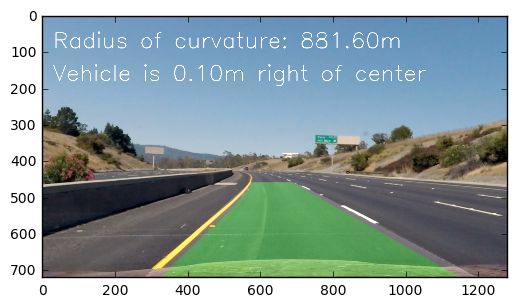

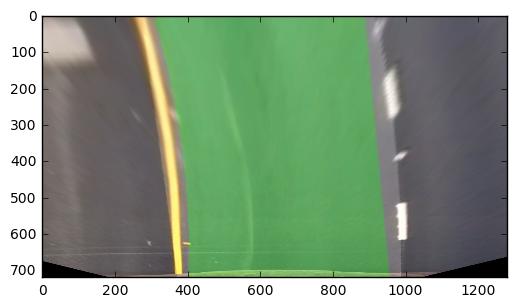

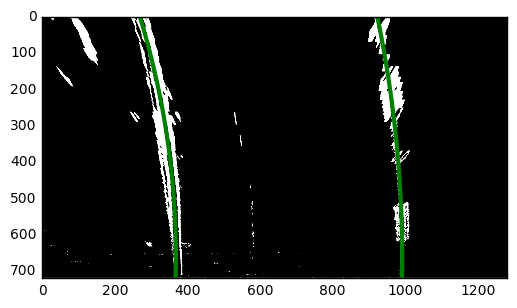

In [13]:
image_name = "./test_images/test11.jpg"
test_image = cv2.imread(image_name)
image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

l_left_line = Line()
l_right_line = Line()

laneImage = adv_lane_id_pipeline(image, l_left_line, l_right_line)
plt.imshow(laneImage)
plt.show()
mpimg.imsave("./output_images/test11_lane.jpg", laneImage)

warped = cv2.warpPerspective(laneImage, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)
plt.show()
mpimg.imsave("./output_images/test11_warped_lane.jpg", warped)

grad = threshold(laneImage)
warped_binary = cv2.warpPerspective(grad, M, img_size, flags=cv2.INTER_LINEAR)
plot_polynomial(warped_binary, l_left_line, l_right_line, "./output_images/test11_warped_poly.jpg")

# Now our radius of curvature is in meters
#print(round(left_line.radius_of_curvature, 2), 'm')
#print(round(right_line.radius_of_curvature, 2), 'm')

## Test on videos

In [14]:
# Similar to Project 1
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
g_left_line = Line()
g_right_line = Line()
def process_image(image):
    global g_left_line
    global g_right_line

    return adv_lane_id_pipeline(image, g_left_line, g_right_line)


### Video 1

In [16]:
project_output_1 = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip_1 = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip_1.write_videofile(project_output_1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 13min 33s, sys: 1min 27s, total: 15min
Wall time: 7min 35s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output_1))